# **Pipeline 1 - Data Ingestion**

In [1]:
# Cell 1: Install specific library versions
!pip install pandas==1.5.3 \
                numpy==1.24.2 \
                sqlalchemy==2.0.8 \
                scikit-learn==1.2.2 \
                matplotlib==3.7.1 \
                seaborn==0.12.2 \
                gradio==4.44.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 24.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 113.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [2]:
# Cell 2: Imports & styling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from sqlalchemy import create_engine

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score

import gradio as gr
import seaborn as sns

# Use default matplotlib style for simplicity
plt.style.use('default')


In [5]:
# Cell 3: Data Ingestion & preview
raw_df = pd.read_csv('USvideos.csv')
print("Raw data shape: ", raw_df.shape)
raw_df.head(3)

Raw data shape:  (40949, 16)


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...


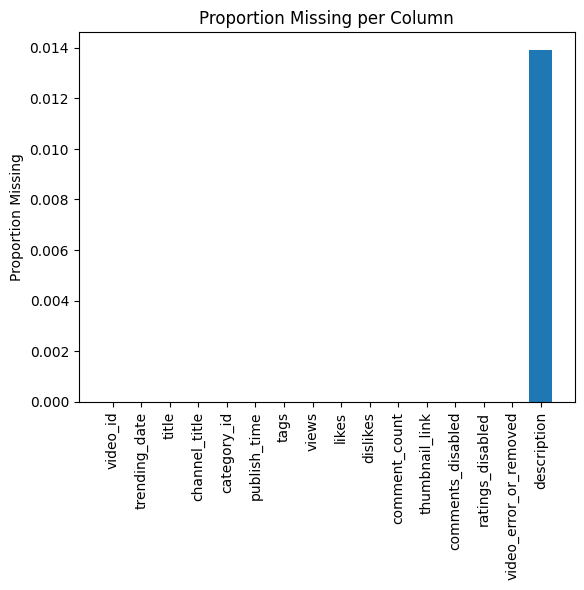

In [6]:
# Cell 4: Missing-value proportions (simple bar chart)
missing = raw_df.isnull().mean()
plt.bar(missing.index, missing.values)
plt.xticks(rotation=90)
plt.ylabel("Proportion Missing")
plt.title("Proportion Missing per Column")
plt.show()

In [7]:
# Cell 5: Save data to SQL
engine = create_engine('sqlite:///youtube_trending.db')
raw_df.to_sql('raw_data', con=engine, if_exists='replace', index=False)

conn = sqlite3.connect('youtube_trending.db')
cnt = pd.read_sql_query("SELECT COUNT(*) AS cnt FROM raw_data", conn).iloc[0,0]
print("Rows in raw_data table:", cnt)

Rows in raw_data table: 40949


# **Pipeline 2 - Data Preprocessing**

In [13]:
# Cell 6: Data cleaning via SQL
c = conn.cursor()
c.execute("""
  CREATE TABLE IF NOT EXISTS cleaned_data AS
  SELECT *
  FROM raw_data
  WHERE views > 0
  AND video_error_or_removed = 0
  AND comments_disabled = 0
""")
conn.commit()

# Compare row counts before and after cleaning
before = pd.read_sql_query("SELECT COUNT(*) AS cnt FROM raw_data", conn).iloc[0,0]
after = pd.read_sql_query("SELECT COUNT(*) AS cnt FROM cleaned_data", conn).iloc[0,0]
print(f"Before cleaning: {before} rows\nAfter cleaning: {after} rows")

# Quick overview of cleaned_data
cleaned_df = pd.read_sql_query("""
  SELECT views, likes, dislikes, comment_count
  FROM cleaned_data
  LIMIT 100
""", conn)
print("Sample of cleaned data:")
display(cleaned_df)

stats = pd.read_sql_query("""
  SELECT
    AVG(views) AS avg_views,
    AVG(likes) AS avg_likes,
    AVG(dislikes) AS avg_dislikes,
    AVG(comment_count) AS avg_comments,
    MIN(views) AS min_views,
    MAX(views) AS max_views
  FROM cleaned_data
""", conn)

pd.set_option('display.float_format', "{:.2f}".format)
print("Summary of cleaned_data:")
display(stats)

Before cleaning: 40949 rows
After cleaning: 40293 rows
Sample of cleaned data:


,views,likes,dislikes,comment_count
0,748374,57527,2966,15954
1,2418783,97185,6146,12703
2,3191434,146033,5339,8181
3,343168,10172,666,2146
4,2095731,132235,1989,17518
...,...,...,...,...
95,836544,40195,373,976
96,284666,16396,81,949
97,3371669,202676,3394,20086
98,195685,14338,171,1070


Summary of cleaned_data:


,avg_views,avg_likes,avg_dislikes,avg_comments,min_views,max_views
0,2358704.80,75111.08,3728.82,8582.86,549,225211923


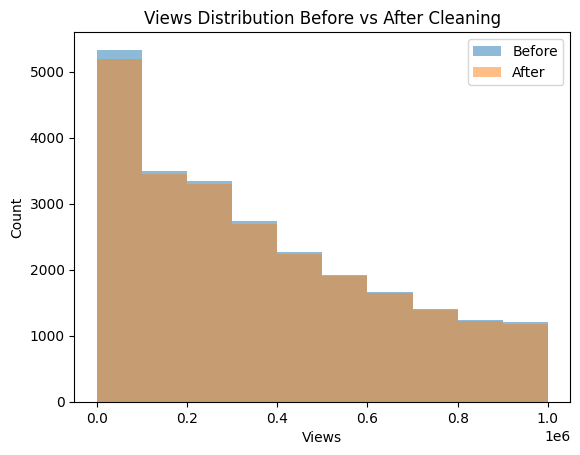

In [15]:
# Cell 7: Views distribution before vs after cleaning (simple histograms)
before_v = pd.read_sql_query("SELECT views FROM raw_data", conn)['views']
after_v = pd.read_sql_query("SELECT views FROM cleaned_data", conn)['views']

plt.hist(before_v, label='Before', alpha=0.5, range=(0, 1e6))
plt.hist(after_v, label='After', alpha=0.5, range=(0, 1e6))
plt.xlabel("Views")
plt.ylabel("Count")
plt.title("Views Distribution Before vs After Cleaning")
plt.legend()
plt.show()

# **Pipeline 3 - Data Exploration**

In [19]:
# Cell 8: Weekly trending video counts (fix date parsing, simple line plot)
monthly = pd.read_sql_query("""
  SELECT
    date(
      '20' || substr(trending_date, 1, 2) || '-' ||
      substr(trending_date, 7, 2) || '-' ||
      substr(trending_date, 4, 2)
    ) AS TrendDate,
    COUNT(*) AS Count
  FROM cleaned_data
  GROUP BY TrendDate
  ORDER BY TrendDate
""", conn)

monthly['TrendDate'] = pd.to_datetime(monthly['TrendDate'], format='%Y-%m-%d')
weekly_counts = monthly.set_index('TrendDate')['Count'].resample('W').sum()

# **Pipeline 4 - Feature Engineering**

# **Pipeline 5 - Model Selection**

# **Pipeline 6 - Hyperparameter Tuning**

# **Pipeline 7 - Model Training and Evaluation**

# **Pipeline 8 - Model Deployment**

In [ ]:
# Cell 16: Gradio Dashboard — Title Length EDA & Extended Top Channels
def show_dashboard():
    # 1) Title length distribution by engagement class
    fig1, ax1 = plt.subplots(figsize=(6,3))
    ax1.hist(df_feat.loc[df_feat.high_engagement==0, 'TitleLength'],
             bins=30, alpha=0.5, label='Low Engagement')
    ax1.hist(df_feat.loc[df_feat.high_engagement==1, 'TitleLength'],
             bins=30, alpha=0.5, label='High Engagement')
    ax1.set_xlabel("Title Length (chars)")
    ax1.set_ylabel("Count")
    ax1.set_title("Title Length by Engagement Class")
    ax1.legend()
    fig1.tight_layout()

    # 2) Tuned model accuracies
    fig2, ax2 = plt.subplots(figsize=(6,3))
    names_list = list(tuned_acc.keys())
    accs = [tuned_acc[n] for n in names_list]
    x = np.arange(len(names_list))
    ax2.bar(x, accs, color='lightgreen')
    ax2.set_xticks(x)
    ax2.set_xticklabels(names_list, rotation=45, ha='right')
    ax2.set_ylim(0,1)
    ax2.set_ylabel("Accuracy")
    ax2.set_title("Tuned Model Accuracies")
    fig2.tight_layout()

    # 3) Top-10 channels by average predicted engagement
    #    using the best RandomForest model
    best_model = tuned_models['RandomForest']
    probs = best_model.predict_proba(X_test)[:,1]
    video_meta = df_feat.loc[X_test.index, ['channel_title']].copy()
    video_meta['pred_high_eng'] = probs
    channel_probs = video_meta.groupby('channel_title')['pred_high_eng'].mean()
    top10_channels = (
        channel_probs
        .sort_values(ascending=False)
        .head(10)
        .reset_index()
        .rename(columns={'pred_high_eng': 'avg_pred_high_eng'})
    )

    # 4) Feature importances of the RandomForest
    importances = best_model.feature_importances_
    imp_df = pd.Series(importances, index=features).sort_values()
    fig4, ax4 = plt.subplots(figsize=(6,3))
    imp_df.plot.barh(ax=ax4)
    ax4.set_title("RandomForest Feature Importances")
    fig4.tight_layout()

    # Return: title-length hist, accuracies bar, top10 DataFrame, importances
    return fig1, fig2, top10_channels, fig4

gr.Interface(
    fn=show_dashboard,
    inputs=[],
    outputs=[
        gr.Plot(label="Title Length by Engagement Class"),
        gr.Plot(label="Tuned Model Accuracies"),
        gr.Dataframe(label="Top 10 Channels by Predicted Engagement"),
        gr.Plot(label="Feature Importances")
    ],
    title="US YouTube Video Engagement Dashboard & Model Insights",
    description="Title length EDA, tuned model performance, top channels, and feature importances."
).launch()
